<a href="https://colab.research.google.com/github/kaleem500bc/Simple-LSTM/blob/master/Simple_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchtext
from torch import nn
import random
from torch.nn import functional as F
import numpy as np
from matplotlib import pyplot as plt
from threading import Thread
import threading

In [ ]:
#Dataset
dataFile = open("/content/anna.txt")

data = dataFile.read()


In [ ]:
#Distinct vocabulary in the dataset
vocab = set(data)

vocab_size = len(vocab)

int2char = dict(enumerate(vocab))

char2int = dict(zip(int2char.values(),int2char.keys()))

In [ ]:
#encode our training dataset for input to the NN
encoded_text = [char2int[i] for i in data]

In [ ]:
def get_batches(encodedText,batchSize,seqLen):
  #Each batch has this size
  totalBatchLen = batchSize*seqLen

  #input batches: Dimension (Number of batches, batch size, sequence length)
  xtotalLen = encodedText.shape[0]
  xnumBatches = xtotalLen//totalBatchLen
  xlength = xnumBatches*totalBatchLen
  xencoded = encodedText[:xlength]
  xencoded = xencoded.view(xnumBatches,batchSize,seqLen)

  #Label
  ytotalLen = encodedText.shape[0]-1
  ynumBatches = ytotalLen // totalBatchLen
  ylength = ynumBatches*totalBatchLen
  yencoded = encodedText[1:ylength+1]
  yencoded = yencoded.view(ynumBatches,batchSize,seqLen)

  return xencoded,yencoded


In [ ]:
batchSize = 128
seqLen = 100
x,y = get_batches(torch.tensor(encoded_text,dtype=torch.float),batchSize,seqLen)
x.requires_grad = True
y.requires_grad = True

In [ ]:
print(x.shape)
print(y.shape)

torch.Size([155, 128, 100])
torch.Size([155, 128, 100])


In [ ]:

#encode each letter into one hot encoding for multiclass classification for better result
#In our case we have vocab_size number of classes as each letter is used as a separate class.
def one_hot(x, labels):
  one_hot = torch.zeros(np.multiply(*x.shape),labels,dtype=torch.float)
  one_hot[torch.arange(one_hot.shape[0]),x.flatten().long()] = 1
  return one_hot.view((*x.shape,labels))



In [ ]:
class lstmM(nn.Module):
  def __init__(self,vocab_size,bidirection=0):
    super().__init__()
    self.hidden = 512
    self.numlayers = 2
    self.bdr = bidirection+1
    # self.embd = nn.Embedding(vocab_size,10)
    self.lstm = nn.LSTM(vocab_size,self.hidden,num_layers=self.numlayers,dropout=0.5,bidirectional=False,batch_first=True)
    self.dropout = nn.Dropout(0.5)
    self.f = nn.Linear(self.hidden*self.bdr,vocab_size)

  def forward(self,x,prevH):
    # x = self.embd(x)
    x,(h,c) = self.lstm(x,prevH)
    x = self.dropout(x)
    x = x.view(-1, self.hidden*self.bdr)
    x = self.f(x)
    
    return x,(h,c)

  def init_hidden(self, batch_size):
    param = self.parameters()
    p = next(param)
    weight = p.data
        
    hidden = (weight.new(self.numlayers*self.bdr, batch_size, self.hidden).zero_().cuda(),
                  weight.new(self.numlayers*self.bdr, batch_size, self.hidden).zero_().cuda())
        
    return hidden


model = lstmM(vocab_size)

model.to("cuda")

lstmM(
  (lstm): LSTM(83, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (f): Linear(in_features=512, out_features=83, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(),lr = 0.01)
lossHist = []


#Run training in background
class Train(Thread):
  def __init__(self,x,y,epoch):
    Thread.__init__(self)
    self.x = x
    self.y = y
    self.epoch = epoch

  def run(self):
    # global lossHist,x,y
    # epoch = 10
    epoch = self.epoch
    x = self.x
    y = self.y
    model.train()
    for e in range(epoch):
      h = model.init_hidden(128)
      tloss = 0

      i = 0
      for batch,target in zip(x,y):
        batch = batch.to("cuda")
        batch = one_hot(batch,vocab_size).to("cuda")
        target = target.to("cuda")
        output,(h,c) = model(batch,h)
        h = (h.detach(),c.detach())
      
        optim.zero_grad()

        loss = criterion(output,target.view(128*100).long())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5)
        optim.step()
        
        tloss = tloss+loss.item()
        
      lossHist.append(tloss)
      print(tloss)




In [ ]:
epoch = 10

#create thread and run
training = Train(x,y,epoch)
training.name = "training"
training.start()
#check whether our thread is running
for thread in threading.enumerate():
  print(thread.name)

In [ ]:
#waiting for the main thread
training.join()

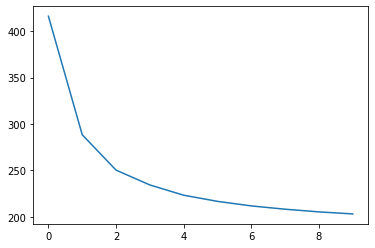

In [ ]:
#plot the loss over epoch
plt.plot(lossHist)

In [ ]:

def predict(char, h=None, top_k=None):
  x=torch.tensor([[char2int[char]]])
  x=one_hot(x,vocab_size)
  x = x.cuda()
  h = tuple([each.data for each in h])
  out, h = model(x, h)
  p=F.softmax(out, dim=1).data
  
  p = p.cpu()
  if top_k is None:
    top_ch = np.arange(vocab_size)
  else:
    p, top_ch = p.topk(top_k)
    top_ch = top_ch.numpy().squeeze()
  p= p.numpy().squeeze()
  char = np.random.choice(top_ch, p=p/p.sum())
  return int2char[char], h

In [ ]:
def sample(size, prime = 'I am goi', top_k = None):
  
  model.cuda()
  model.eval()
  
  chars = [ch for ch in prime]
  h = model.init_hidden(1)

  for ch in prime:
    char, h= predict(ch, h, top_k=top_k)
  chars.append(char)

  for ii in range(size):
    char, h = predict(chars[-1], h, top_k=top_k)
    chars.append(char)
  return ''.join(chars)

In [ ]:
print(sample(1000,prime="I am goin"))

I am going
to
the same thing,
and you know I knot him but significanations that uptly that the officer, and been like its
second pain weary hating any window, and had
seeing the due with his wife.

Swe will understand thoogse do they? How are you an one
to the
teach whole note, thiugh he refund for, Who did
not do cold, cleft he dropped on the mind,
country with his influence
cold mounte stack of patain is
kinchantous after the sire of which
except his hands who was trying
merely tears with it is!" he said, strusking himself, and he advised ever digination
with their blook to place by which hame. Anna answered, and ask without the urmmenty in what Snoped not help their
passadence then it was Alexey Alexandrovitch, responded from the box to snot sent to be going out when the horse drave stopped over the group by these day, with him. Without any bebuskys and speaking and trousering crowd and thinking of all, and been over.

"Oh, roomek minute to yevcontant
Grisha out of everything for my